# Machine learning
## TASK 8
## Importing data

In [81]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn-v0_8")

def nrmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (np.max(y_true)-np.min(y_true))
    
df = pd.read_csv("train_253253.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
df = df.set_index("timestamp")
df = df.asfreq("h") 
df.index = df.index.tz_convert(None)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2013-07-01 00:00:00 to 2014-06-30 23:00:00
Freq: h
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pv_mod1                          8321 non-null   float64
 1   pv_mod2                          8268 non-null   float64
 2   pv_mod3                          8249 non-null   float64
 3   Demand                           8759 non-null   float64
 4   pv                               8759 non-null   float64
 5   Price                            8759 non-null   float64
 6   Temperature                      8759 non-null   float64
 7   Pressure (hPa)                   8759 non-null   float64
 8   Cloud_cover (%)                  8759 non-null   float64
 9   Cloud_cover_low (%)              8759 non-null   float64
 10  Cloud_cover_mid (%)              8759 non-null   float64
 11  Cloud_cover_high (%)             8759 

In [72]:
demand = df[['Demand']]
demand.head()

,Demand
timestamp,
2013-07-01 00:00:00,0.27
2013-07-01 01:00:00,0.23
2013-07-01 02:00:00,0.26
2013-07-01 03:00:00,0.28
2013-07-01 04:00:00,0.29


## Baseline forecast

In [69]:
time_data = demand.copy()
time_data['ts'] = pd.to_datetime(time_data.index.values, dayfirst=True)
time_data = time_data.drop(columns=['Demand'])
time_data['wd'] = time_data['ts'].dt.dayofweek
time_data['h'] = time_data['ts'].dt.hour

time_data["h_sin"] = np.sin(2 * np.pi * time_data["h"] / 24)
time_data["h_cos"] = np.cos(2 * np.pi * time_data["h"] / 24)

time_data["dow_sin"] = np.sin(2 * np.pi * time_data["wd"] / 7)
time_data["dow_cos"] = np.cos(2 * np.pi * time_data["wd"] / 7)

time_data

,ts,wd,h,h_sin,h_cos,dow_sin,dow_cos
timestamp,,,,,,,
2013-07-01 00:00:00,2013-07-01 00:00:00,0,0,0.000000,1.000000,0.0,1.0
2013-07-01 01:00:00,2013-07-01 01:00:00,0,1,0.258819,0.965926,0.0,1.0
2013-07-01 02:00:00,2013-07-01 02:00:00,0,2,0.500000,0.866025,0.0,1.0
2013-07-01 03:00:00,2013-07-01 03:00:00,0,3,0.707107,0.707107,0.0,1.0
2013-07-01 04:00:00,2013-07-01 04:00:00,0,4,0.866025,0.500000,0.0,1.0
...,...,...,...,...,...,...,...
2014-06-30 19:00:00,2014-06-30 19:00:00,0,19,-0.965926,0.258819,0.0,1.0
2014-06-30 20:00:00,2014-06-30 20:00:00,0,20,-0.866025,0.500000,0.0,1.0
2014-06-30 21:00:00,2014-06-30 21:00:00,0,21,-0.707107,0.707107,0.0,1.0


In [70]:
#control
features = features.drop(columns=["Demand"], errors="ignore")
print(demand.columns)
print(features.columns)


Index(['Demand'], dtype='object')
Index(['lag7', 'lag1', 'Temperature', 'ts', 'wd', 'h', 'h_sin', 'h_cos',
       'dow_sin', 'dow_cos', 'Price'],
      dtype='object')


In [77]:
lag7d = demand[['Demand']].shift(24*7)
lag7d = lag7d.rename(columns = {'Demand':'lag7'})
lag1d = demand[['Demand']].shift(24)
lag1d = lag1d.rename(columns = {'Demand':'lag1'})

temperature = df[['Temperature']]
temperature = temperature.rename(columns = {'Temperature':'temp'})
price = df[['Price']]
price = price.rename(columns = {'Price':'el_price'})

features = lag7d.copy()
features = features.join(lag1d) #doent using lag1 for now
features = features.join(temperature)
features = features.join(time_data)
features = features.join(price)
#features.tail()

dataset = demand.join(features)
dataset.tail()

,Demand,lag7,lag1,temp,ts,wd,h,h_sin,h_cos,dow_sin,dow_cos,el_price
timestamp,,,,,,,,,,,,
2014-06-30 19:00:00,2.32,0.39,0.63,15.2,2014-06-30 19:00:00,0,19,-0.965926,0.258819,0.0,1.0,0.10027
2014-06-30 20:00:00,0.99,0.53,0.61,14.8,2014-06-30 20:00:00,0,20,-0.866025,0.500000,0.0,1.0,0.09997
2014-06-30 21:00:00,0.50,0.34,0.43,13.9,2014-06-30 21:00:00,0,21,-0.707107,0.707107,0.0,1.0,0.05193
2014-06-30 22:00:00,0.35,0.27,0.27,13.4,2014-06-30 22:00:00,0,22,-0.500000,0.866025,0.0,1.0,0.09702
2014-06-30 23:00:00,0.31,0.27,0.24,13.2,2014-06-30 23:00:00,0,23,-0.258819,0.965926,0.0,1.0,0.09601


In [103]:
fs1 = ['lag7']
fs2 = ['lag7', 'lag1']
fs3 = ['lag7', 'lag1','temp']
fs4 = ['lag7', 'lag1','temp','h_sin','h_cos','dow_sin','dow_cos']
fs5 = ['temp', 'lag1','h_sin','h_cos','dow_sin','dow_cos']
fs6 = ['lag7','lag1', 'h_sin','h_cos','dow_sin','dow_cos']
fs7 = ['h_sin','h_cos','dow_sin','dow_cos']
fs8 = ['el_price','h_sin','h_cos','dow_sin','dow_cos']
fs9 = ['el_price','lag7','lag1','h_sin','h_cos','dow_sin','dow_cos']
#fs10 = ['temp', 'lag7', 'h_sin','h_cos','dow_sin','dow_cos']

#fs = [fs1, fs2, fs3, fs4, fs5, fs6, fs7, fs8, fs9]
fs = [fs1, fs5, fs8]

lag7
MAPE: 46.140 MAE: 0.240 RMSE: 0.377
temp lag1 h_sin h_cos dow_sin dow_cos
MAPE: 36.018 MAE: 0.211 RMSE: 0.361
el_price h_sin h_cos dow_sin dow_cos
MAPE: 36.851 MAE: 0.209 RMSE: 0.356
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}


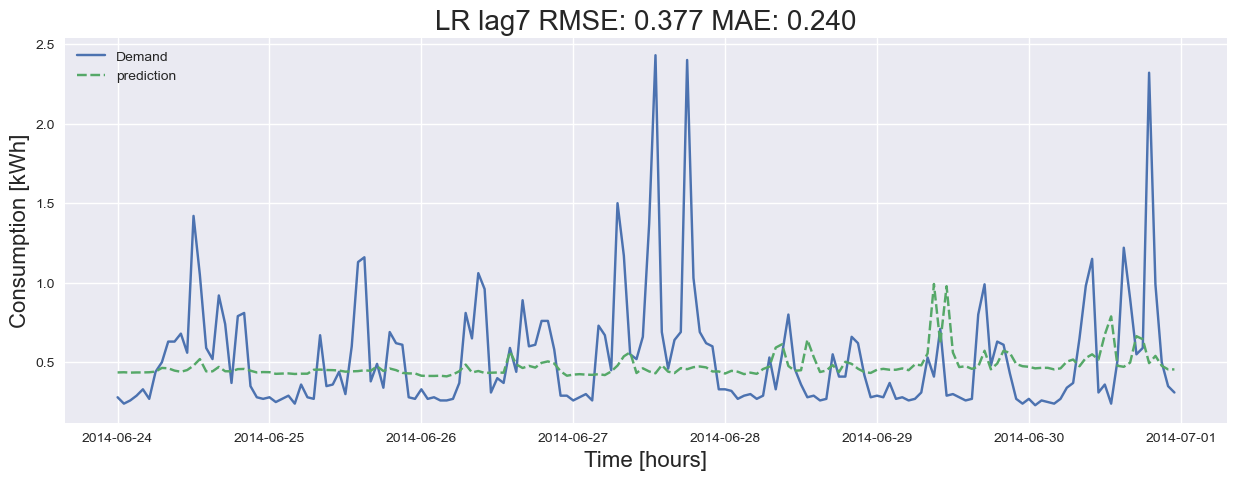

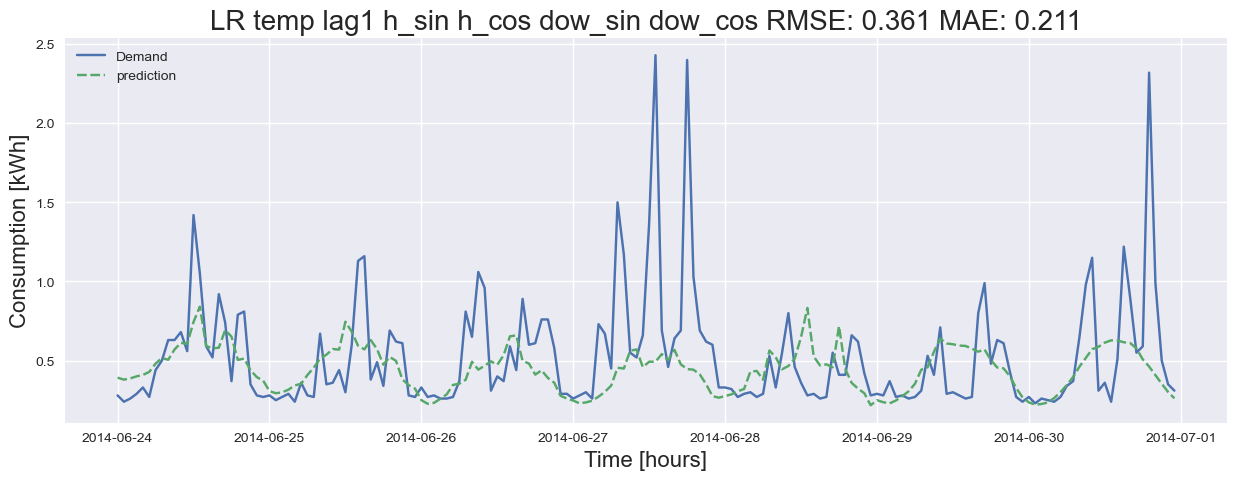

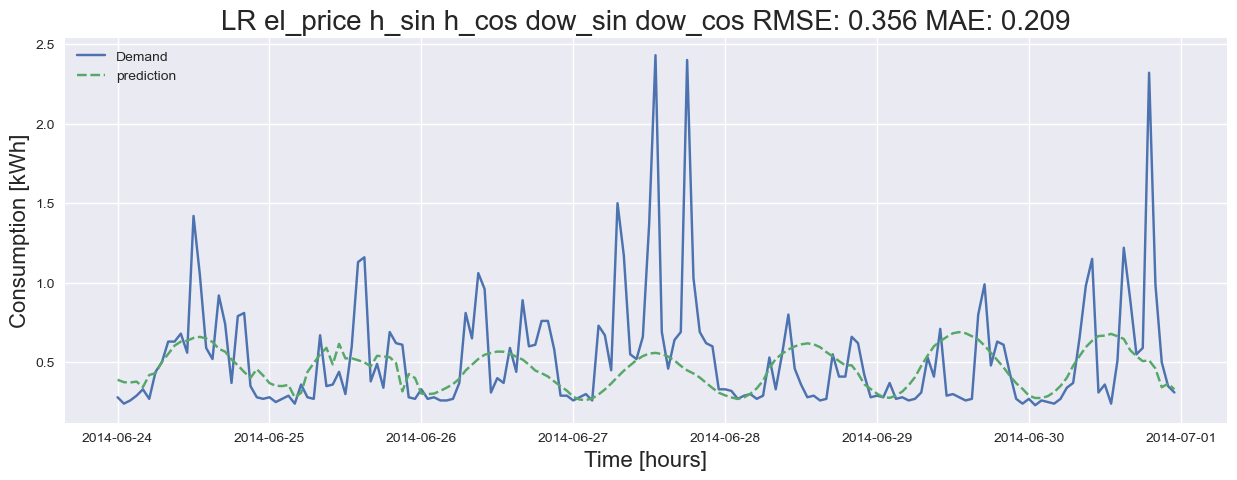

In [110]:
predict_days = 7
training_data_length =14
last_dataset_day = dataset.index.max().date()
prediction_start = pd.to_datetime(last_dataset_day - timedelta(days = predict_days-1))

#print(prediction_start)
#print(last_dataset_day)

def rolling_lr_forecast(ad_fs):
  actual_full = pd.DataFrame()
  forecast_full = pd.DataFrame()

  for d in range(0,predict_days):

    predict_for_start = pd.to_datetime(prediction_start + timedelta(days = d))
    predict_for_end = pd.to_datetime(predict_for_start + timedelta(days = 1))

    training_end = pd.to_datetime(predict_for_start - timedelta(days = 1))
    training_start = pd.to_datetime(training_end - timedelta(days = training_data_length))

    test_set = dataset[(dataset.index >= predict_for_start) &  (dataset.index < predict_for_end)]
    train_set = dataset[(dataset.index >= training_start) &  (dataset.index < training_end)]

    X_test = test_set[ad_fs]
    y_test = test_set[['Demand']]

    X_train = train_set[ad_fs]
    y_train = train_set[['Demand']]

    model = LinearRegression()
    model.fit(X_train,y_train)
    

    predictions =  pd.DataFrame(model.predict(X_test))
    predictions.set_index(y_test.index, inplace=True)
    predictions = predictions.rename(columns = {0:'prediction'})

    actual_full = pd.concat([actual_full, y_test])#, ignore_index=True)
    forecast_full = pd.concat([forecast_full, predictions])#, ignore_index=True)

##############################
  mapestring="MAPE: %.3f" % (mean_absolute_percentage_error(actual_full, forecast_full)*100)
  maestring="MAE: %.3f" % (mean_absolute_error(actual_full, forecast_full))
  rmsestring = "RMSE: %.3f" % (np.sqrt(mean_squared_error(actual_full, forecast_full)))


  plt.figure(figsize=(15,5))
  p = sns.lineplot(data = actual_full.join(forecast_full));
  plt.title("LR " + " ".join(ad_fs)+" "+rmsestring+" "+maestring, fontsize = 20)
  p.set_xlabel("Time [hours]", fontsize = 16);
  p.set_ylabel("Consumption [kWh]", fontsize = 16);
  #plt.show()

  print( " ".join(ad_fs))
  print(mapestring+" "+maestring+" "+rmsestring)

  #print(str(predict_for_start)+" "+ str(training_start)+" "+str(training_end))

for ad_fs in fs:
  rolling_lr_forecast(ad_fs)

model_param = LinearRegression()
print(model_param.get_params())

## Prophet

In [89]:
time_data_prop = demand.copy()
time_data_prop = time_data_prop.drop(columns=['Demand'])
time_data_prop['ds'] = pd.to_datetime(time_data.index.values, dayfirst=True)

dataset_prop = demand.join(time_data_prop)

dataset_prop.rename(columns={'Demand': 'y'}, inplace=True)
#dataset.reset_index(drop=True, inplace=True)
dataset_prop.tail()

,y,ds
timestamp,,
2014-06-30 19:00:00,2.32,2014-06-30 19:00:00
2014-06-30 20:00:00,0.99,2014-06-30 20:00:00
2014-06-30 21:00:00,0.50,2014-06-30 21:00:00
2014-06-30 22:00:00,0.35,2014-06-30 22:00:00
2014-06-30 23:00:00,0.31,2014-06-30 23:00:00


In [93]:
predict_days = 7
training_data_length = 14

last_dataset_prop_day = dataset_prop.index.max().date()
prediction_start = pd.to_datetime(last_dataset_prop_day - pd.Timedelta(days=predict_days-1))




# (Optional) resample to daily if you want day-ahead with daily y
# dfp = dfp.set_index("ds").resample("D").sum().reset_index()

# Build Prophet model; add seasonality as needed
m = Prophet(
    daily_seasonality=True,   # set to True if sub-daily data
    weekly_seasonality=True,
    yearly_seasonality=False
)

# (Optional) extra regressors—if you have them in dataset, add and include in dfp
# for reg in ad_fs:
#     m.add_regressor(reg)
#     dfp[reg] = dataset[reg].values  # make sure aligned

# Fit on the full df (CV will internally refit on each cutoff subset)
# from the official prophet documentation: "Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long.
# It will also fit daily seasonality for a sub-daily time series."
# I also manually added the trend changepoint detection parameter to make the model more flexible and added country-specific holidays.
m.add_country_holidays(country_name='EE')

m.fit(dataset_prop)

# Built-in CV: rolling 14-day train, 1-day horizon, step 1 day
df_cv = cross_validation(
    m,
    initial=f"{training_data_length} days",
    period="1 days",
    horizon="1 days",
    parallel=None  # set to "processes" to speed up if desired
)

# Keep only the last 7 forecasted days (yhat for the day after each cutoff)
mask_last7 = (df_cv["ds"].dt.date >= prediction_start.date()) & (df_cv["ds"].dt.date <= last_dataset_prop_day)
df_cv_last7 = df_cv.loc[mask_last7].copy()

# Metrics (overall for those 7 days)
df_pm = performance_metrics(df_cv_last7, rolling_window=1)  # no smoothing
overall_mae = df_pm["mae"].mean()
overall_mape = df_pm["mape"].mean()
overall_rmse = df_pm["rmse"].mean()
print({"MAE": overall_mae, "MAPE": overall_mape, "RMSE": overall_rmse})

# If you want aligned actual/forecast series:
actual_full = df_cv_last7[["ds", "y"]].set_index("ds").rename(columns={"y": "demand"})
forecast_full = df_cv_last7[["ds", "yhat"]].set_index("ds").rename(columns={"yhat": "prediction"})

12:26:09 - cmdstanpy - INFO - Chain [1] start processing
12:26:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/350 [00:00<?, ?it/s]

12:26:13 - cmdstanpy - INFO - Chain [1] start processing
12:26:13 - cmdstanpy - INFO - Chain [1] done processing
12:26:13 - cmdstanpy - INFO - Chain [1] start processing
12:26:13 - cmdstanpy - INFO - Chain [1] done processing
12:26:13 - cmdstanpy - INFO - Chain [1] start processing
12:26:13 - cmdstanpy - INFO - Chain [1] done processing
12:26:13 - cmdstanpy - INFO - Chain [1] start processing
12:26:13 - cmdstanpy - INFO - Chain [1] done processing
12:26:13 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing
12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing
12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing
12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1] done processing
12:26:14 - cmdstanpy - INFO - Chain [1] start processing
12:26:14 - cmdstanpy - INFO - Chain [1]

{'MAE': 0.18854776890905572, 'MAPE': 0.3180458843881668, 'RMSE': 0.34032138264612233}


MAPE: 31.805 MAE: 0.189 RMSE: 0.340


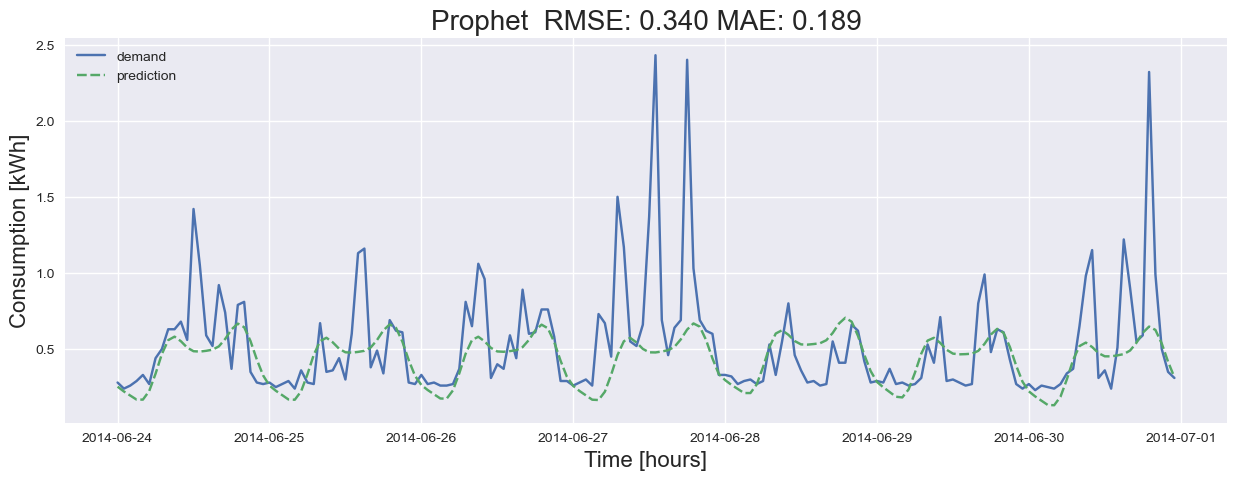

In [95]:
mapestring="MAPE: %.3f" % (overall_mape*100)
maestring="MAE: %.3f" % (overall_mae)
rmsestring = "RMSE: %.3f" % (overall_rmse)

print(mapestring+" "+maestring+" "+rmsestring)

plt.figure(figsize=(15,5))
p = sns.lineplot(data = actual_full.join(forecast_full));
plt.title("Prophet " +" "+rmsestring+" "+maestring,fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [kWh]", fontsize = 16);